# Results

Continuous Model :
    Kaggle Score: 5.55679
    RMSE: 0.18

Baseline Model: Kaggle Score: 2.97070 RMSE: 0.17

Category + Continuous Model: Kaggle Score: 1.02508 RMSE: 0.15

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from joblib import dump, load
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
ROOT_DIR = Path('.').resolve().parents[1].absolute()
DATA_DIR = ROOT_DIR / 'data' / 'house-prices'

target_column = 'SalePrice'

In [3]:
# Import the python functions necessary
sys.path.append(str(ROOT_DIR))
from app.housingprice import read_data, train_preprocessing, xgb_model, predict, compute_rmsle, cont_inference ,baseline_inference, predict_inference, category_cont_inference, fill_negatives, prepare_submission, validate_missing_predictions

In [4]:
%load_ext autoreload

In [ ]:
%autoreload

In [4]:
df_master = read_data(DATA_DIR / 'train.csv')

In [6]:
df_master.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Pre-processing

## Continuous data

In [5]:
df_continuous = train_preprocessing(df_master, [], 1)

In [6]:
df_continuous.shape

(1121, 37)

## Baseline model

In [9]:
df_base = df_master.select_dtypes(include='number').copy()
df_base.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [10]:
df_base.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

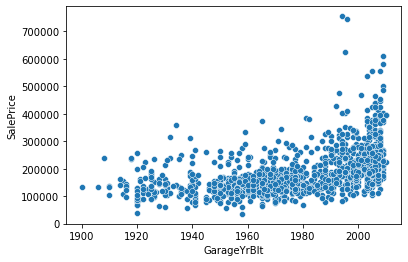

In [11]:
sns.scatterplot(data=df_base, x='GarageYrBlt', y=target_column)

In [30]:
cont_cols = df_base.columns

<AxesSubplot:>

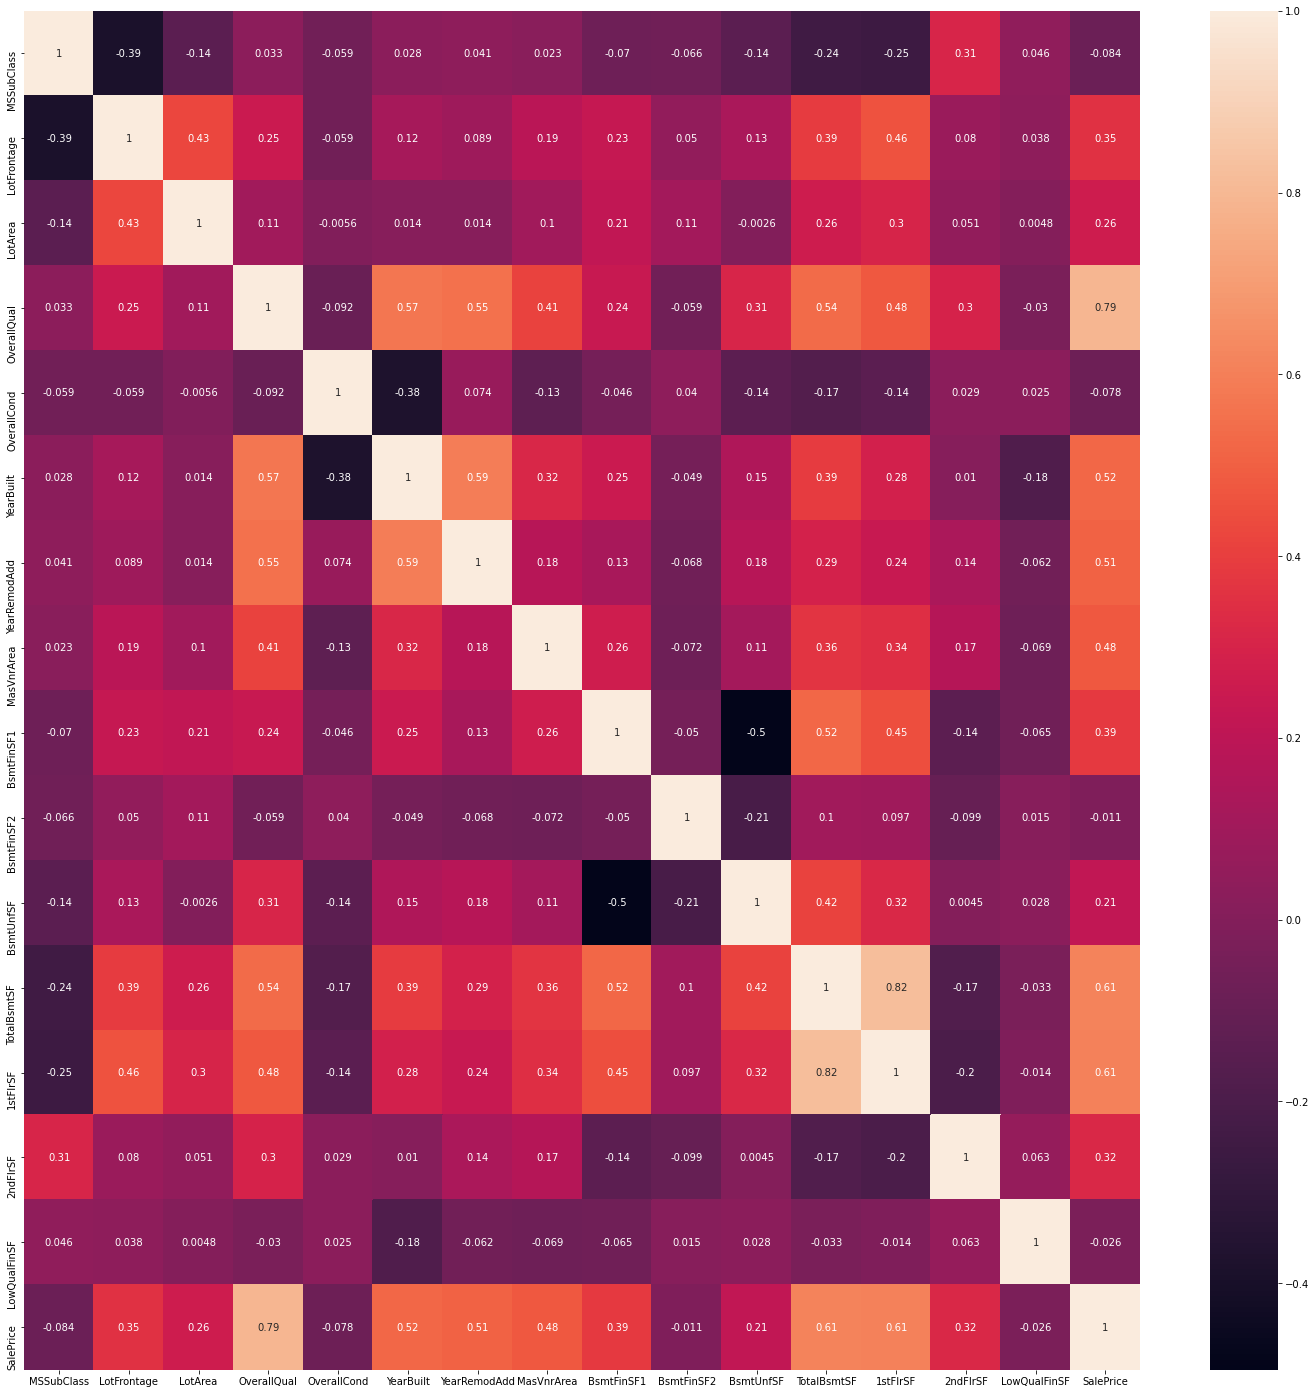

In [13]:
plt.figure(figsize=(25,25))
sns.heatmap(df_base[list(cont_cols[:15]) + [target_column]].corr(), annot=True)

<AxesSubplot:>

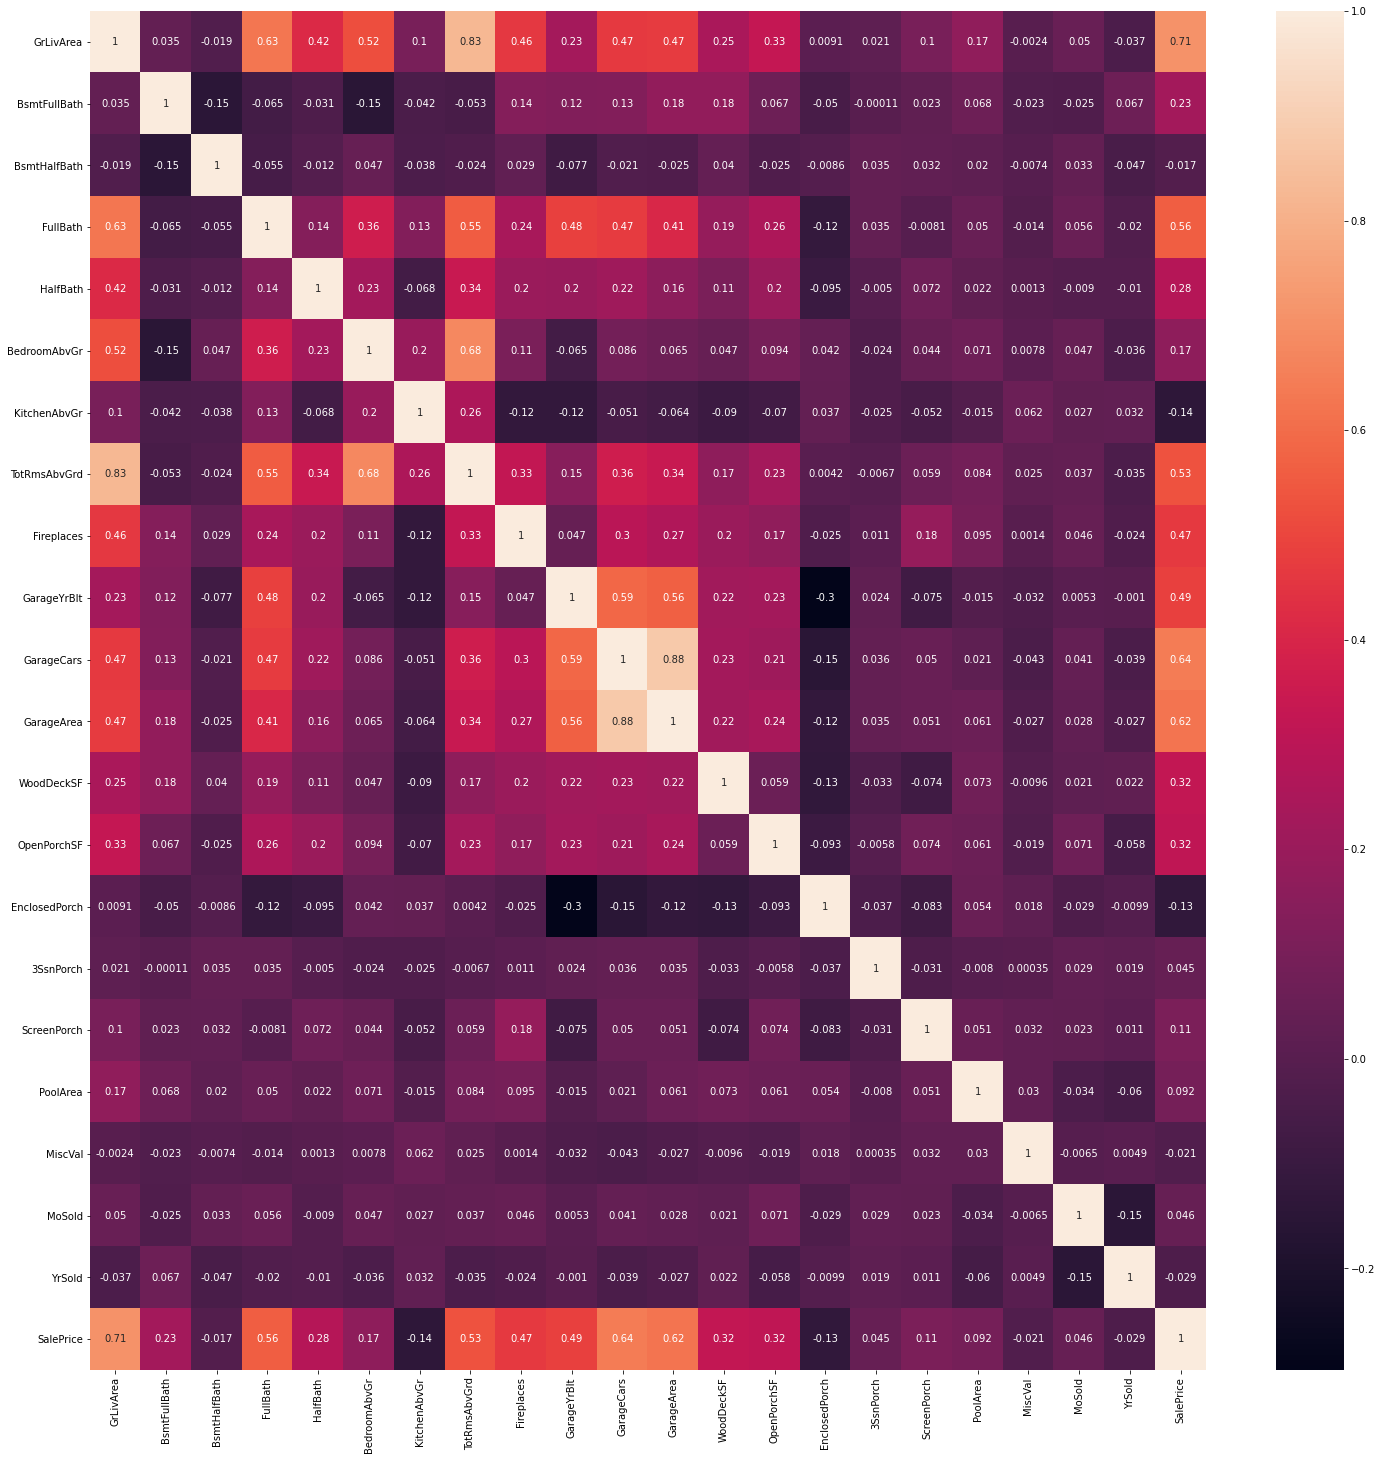

In [14]:
plt.figure(figsize=(25,25))
sns.heatmap(df_base[cont_cols[15:]].corr(), annot=True)

In [15]:
to_drop = ['BsmtFinSF2', 'YrSold', 'BsmtHalfBath']
df_base = train_preprocessing(df_base, to_drop, 2)

In [16]:
df_base.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,150,856,856,854,0,1710,1,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,284,1262,1262,0,0,1262,0,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,434,920,920,866,0,1786,1,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,540,756,961,756,0,1717,1,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,490,1145,1145,1053,0,2198,1,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,250000


## Categorical and Continuous model

In [7]:
df = df_master

In [113]:
df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
188,50,RL,60.0,10410,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,7,1916,1987,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,660,660,GasA,Ex,Y,SBrkr,808,704,144,1656,0,0,2,1,3,1,TA,8,Min2,0,None,Detchd,1916,Unf,1,180,Fa,Fa,N,0,0,0,140,0,0,None,MnPrv,None,0,8,2009,WD,Normal,135000,0,1,1,1,0
776,120,RM,32.0,4500,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1998,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,320.0,TA,TA,PConc,Ex,TA,No,GLQ,866,Unf,0,338,1204,GasA,Ex,Y,SBrkr,1204,0,0,1204,1,0,2,0,2,1,TA,5,Typ,0,None,Attchd,1998,Fin,2,412,TA,TA,Y,0,247,0,0,0,0,None,None,None,0,6,2009,WD,Normal,162000,0,0,1,1,0
630,80,RL,82.0,9020,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Feedr,Norm,1Fam,SLvl,6,5,1964,1964,Gable,WdShngl,Plywood,Wd Sdng,BrkFace,259.0,TA,TA,CBlock,TA,TA,Gd,GLQ,624,Rec,336,288,1248,GasA,TA,Y,SBrkr,1350,0,0,1350,1,0,1,1,3,1,TA,6,Typ,0,None,Attchd,1964,RFn,2,520,TA,TA,Y,176,0,0,0,0,0,None,GdPrv,None,0,6,2008,WD,Normal,168500,0,0,1,1,0
278,20,RL,140.0,19138,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,4,5,1951,1951,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,LwQ,120,Unf,0,744,864,GasA,Ex,Y,SBrkr,864,0,0,864,0,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1951,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2010,WD,Normal,141000,0,0,1,1,0
18,90,RL,72.0,10791,Pave,Shed,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1296,0,0,1296,0,0,2,0,2,2,TA,6,Typ,0,None,CarPort,1967,Unf,2,516,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,500,10,2006,WD,Normal,90000,0,0,1,0,0


In [8]:
null_cols = df.isnull().columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

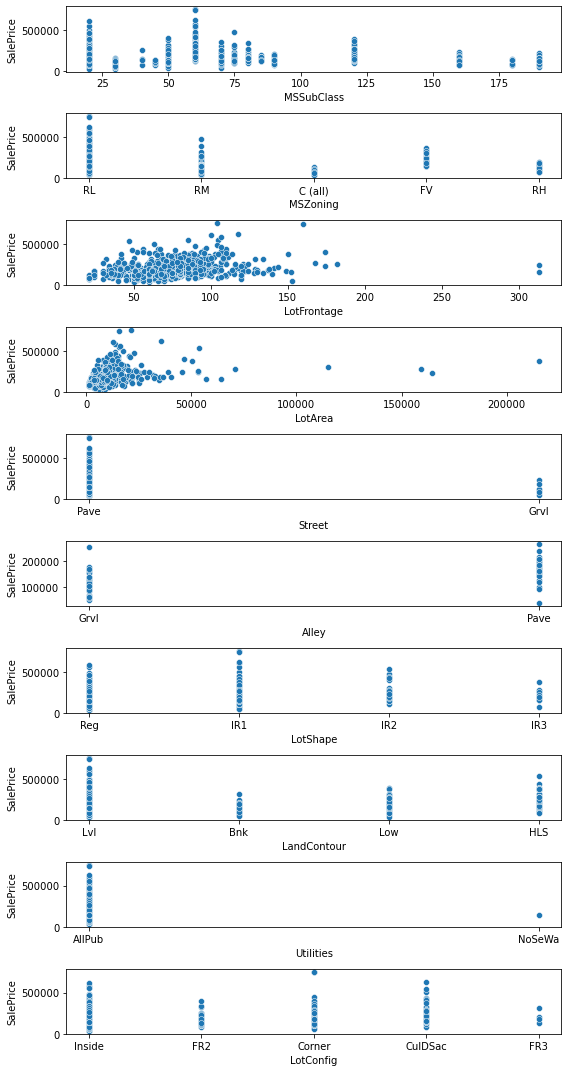

In [9]:
fig, ax = plt.subplots(10, 1, figsize=(8,15))

i = 0
for col in null_cols[:10]:
    sns.scatterplot(data=df, x=col, y=target_column, ax=ax[i])
    i += 1

fig.tight_layout()

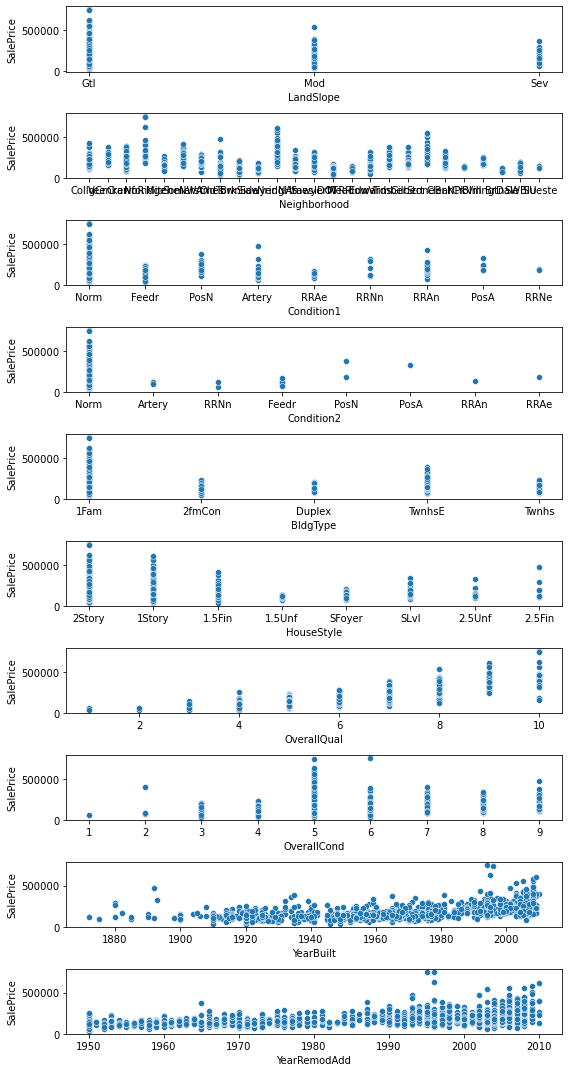

In [10]:
fig, ax = plt.subplots(10, 1, figsize=(8,15))

i = 0
for col in null_cols[10:20]:
    sns.scatterplot(data=df, x=col, y=target_column, ax=ax[i])
    i += 1

fig.tight_layout()

In [8]:
to_drop = ['Street','Utilities', 'PoolQC', 'GarageYrBlt']

In [9]:
df = train_preprocessing(df, to_drop, 3)

In [10]:
df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC

# Model training

In [11]:
df_final = df

In [12]:
X, y, X_train, X_test, y_train, y_test = split_data(df_final)

In [13]:
from xgboost import XGBRegressor

model = xgb_model(X_train, y_train)

In [29]:
dump(model, ROOT_DIR / 'models' / 'xgb_model.pkl')

['C:\\Users\\Subaandh\\Desktop\\DSA_P\\dsa-dsp-subaandh-VK\\models\\xgb_model.pkl']

# Model evaluation

In [14]:
y_pred = predict(model, X_test)

In [15]:
compute_rmsle(y_test, y_pred) 

0.13

# Inference

In [16]:
inference_df = pd.read_csv(DATA_DIR / 'test.csv', index_col='Id')

In [17]:
inference_df.shape

(1459, 79)

## Continuous model

In [67]:
continuous_inference_df = cont_inference(inference_df)

In [68]:
predictions = predict_inference(continuous_inference_df, model)
predictions

array([116907.09633235, 121848.25283429, 170443.82676196, ...,
        58217.46991203, 168332.21819205, 260027.6061591 ])

In [69]:
continuous_inference_df.shape

(1146, 36)

## Baseline inference

In [145]:
base_inference_df = baseline_inference(inference_df, to_drop)

In [147]:
base_inference_df.shape

(1459, 25)

In [153]:
predictions = predict_inference(base_inference_df, model)
predictions

## improved data Inference

In [18]:
imp_inference_df = inference_df

In [19]:
imp_inference_df = category_cont_inference(inference_df, to_drop)

In [20]:
predictions = model.predict(imp_inference_df)
predictions

array([130736.984, 169107.12 , 185700.31 , ..., 152531.3  , 118547.27 ,
       227125.81 ], dtype=float32)

## Fill negatives

In [21]:
predictions = fill_negatives(predictions)
len(predictions)

1459

# Submission

## Prepare Submission

In [22]:
final_inference_df = imp_inference_df

In [23]:
submission_df, final_inference_df, final_inference_ids_df = prepare_submission(inference_df, final_inference_df, predictions)
submission_df.head()

Number of missing predictions {0}


,Id,SalePrice
0,1461,130736.984375
1,1462,169107.125000
2,1463,185700.312500
3,1464,200642.250000
4,1465,184030.562500


## Validate Missing predictions

In [24]:
final_id = final_inference_df
df_final = final_inference_ids_df

In [25]:
submission_df = validate_missing_predictions(submission_df, df_final, final_id)

## Create Submission file

In [26]:
# Save submission file
submission_file_path = DATA_DIR / 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

In [27]:
res = pd.read_csv(DATA_DIR / 'submission.csv')
res.head()

,Id,SalePrice
0,1461,130736.984
1,1462,169107.120
2,1463,185700.310
3,1464,200642.250
4,1465,184030.560


In [28]:
len(res)

1459